## Overview

You are just hired as a Sr. Data Scientist at City of Chicago. You manager, mayor, Mr. Emanuel, asked you to download the dataset from https://www.kaggle.com/chicago/chicago-taxi-rides-2016.. It is a very large dataset containing about 20 million records. This dataset includes taxi trips for 2016, reported to the City of Chicago in its role as a regulatory agency. To protect privacy but allow for aggregate analyses, the Taxi ID is consistent for any given taxi medallion number but does not show the number, Census Tracts are suppressed in some cases, and times are rounded to the nearest 15 minutes. Due to the data reporting process, not all trips are reported but the City believes that most are. See http://digital.cityofchicago.org/index.php/chicago-taxi-data-released (Links to an external site.)Links to an external site. for more information about this dataset and how it was created.

The dataset contains the following features in 12 monthly files:
+ taxi_id - A unique identifier for the taxi.
+ trip_start_timestamp - When the trip started, rounded to the nearest 15 minutes.
+ trip_end_timestamp - When the trip ended, rounded to the nearest 15 minutes.
+ trip_seconds - Time of the trip in seconds.
+ trip_miles - Distance of the trip in miles.
+ pickup_census_tract - The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.
+ dropoff_census_tract - The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.
+ pickup_community_area - The Community Area where the trip began.
+ dropoff_community_area - The Community Area where the trip ended.
+ fare - The fare for the trip.
+ tips - The tip for the trip. Cash tips generally will not be recorded.
+ tolls - The tolls for the trip.
+ extras - Extra charges for the trip.
+ trip_total - Total cost of the trip, the total of the fare, tips, tolls, and extras.
+ payment_type - Type of payment for the trip.
+ company - The id code for the taxi company.
+ pickup_latitude - The id code for the latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
+ pickup_longitude - The id code for the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
+ pickup_location - The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
+ dropoff_latitude - The id code for the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
+ dropoff_longitude - The id code for the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
+ dropoff_location - The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.

## Objectives

You are asked to perform the following tasks:

1. Read 12 monthly datasets, chicago_taxi_trips_2016_01, chicago_taxi_trips_2016_02, …, chicago_taxi_trips_2016_12 into a Spark Data frame(Hint: you can use df = spark.read.csv('C:\\Users\\yliu3\\Documents\\Data Banks\\Regression\\chicago-taxi-rides-2016\\*.csv', header = True, inferSchema = True) to read several csv files and combine it into a single data frame)
2. There are some missing values in fare ,trip_seconds,  and trip_miles , please drop the NAs in these three columns only using df = df.na.drop(subset= []) 
3. You are asked to forecast fare using trip_seconds, trip_miles and Build a linear regression with elastic net Regularizers.
4. You are asked to forecast fare using trip_seconds, trip_miles and Build a simple tree model.
5. You are asked to forecast fare using trip_seconds, trip_miles and Build a random forest model.
6. You are asked to forecast fare using trip_seconds, trip_miles and Build a Gradient-Boosted Tree
7. Which model do you recommend to use? Justify your answer.
8. Please perform hyper parameter tuning on the model you selected in step 7 (since it is a huge dataset, you may use 1 parameter for each hyperparameters to save time)
9. Perform k-means clustering using features trip_seconds, trip_miles, and fare. Please recommend the optimal number of clusters and justify your answer.

Please develop your models. You may get help from your classmates. When you debug the models, you may use a smaller dataset, for example , 5,000 rows. After you fix all bugs, then run the whole dataset, for example at 9pm, then you will get some results in the morning,

Since it is a very large dataset, it takes about 12 hours on my laptop to run all the models. You need to summarize your model results in a PPT file and present your own research finding on Monday, December 11 or Wednesday, December 13,  2022 in the classroom.

## Setup
**Task 1:** Read 12 monthly datasets, chicago_taxi_trips_2016_01, chicago_taxi_trips_2016_02, …, chicago_taxi_trips_2016_12 into a Spark Data frame

In [1]:
# setup spark session

import findspark
from pyspark.sql import SparkSession

findspark.init()

spark = SparkSession\
    .builder\
    .appName("FinalProject")\
    .getOrCreate()

In [2]:
# import libraries
import os
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import trim
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline 
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans

# initialize start time
start_time = time()

In [3]:
# bring in the data

# time the codes
t0 = time()

# set up file directory and get file names
file_directory = r'C:\Users\lucky\OneDrive - Maryville University\03 College 23-24 S1\DSCI-417 Big Data Analytics\HW and Projects\Final Project\chigago_taxi_trips_2016_data'
file_names = os.listdir(file_directory)

# import first file
df = spark.read.csv(os.path.join(file_directory,file_names[0]),header=True,inferSchema=True)
# loop over other file names to put all the data in one data frame
for file in file_names[1:]:
    file_path = os.path.join(file_directory,file)
    temp_df = spark.read.csv(file_path, header=True, inferSchema=True)
    df = df.union(temp_df)
    
print("time to run:",round(time()-t0,2),"seconds")

time to run: 51.79 seconds


In [4]:
df.printSchema()

root
 |-- taxi_id: integer (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: string (nullable = true)
 |-- dropoff_census_tract: integer (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: integer (nullable = true)
 |-- pickup_latitude: integer (nullable = true)
 |-- pickup_longitude: integer (nullable = true)
 |-- dropoff_latitude: integer (nullable = true)
 |-- dropoff_longitude: integer (nullable = true)



## Pre-Processing
**Task 2:** There are some missing values in fare ,trip_seconds, and trip_miles, please drop the NAs in these three columns only using df = df.na.drop(subset= [])

In [5]:
# drop NAs
clean_df = df.na.drop(subset=['fare','trip_seconds','trip_miles'])

In [6]:
clean_df.select(['fare','trip_seconds','trip_miles']).summary().show()

+-------+-----------------+------------------+-----------------+
|summary|             fare|      trip_seconds|       trip_miles|
+-------+-----------------+------------------+-----------------+
|  count|         19665487|          19665487|         19665487|
|   mean|13.90642006780711| 767.0855416395231|3.401188760796607|
| stddev|25.36819333238986|1059.8733008720935|22.70385052601448|
|    min|              0.0|                 0|              0.0|
|    25%|             6.25|               300|              0.1|
|    50%|              8.5|               540|              1.1|
|    75%|            14.25|               900|              2.7|
|    max|           9999.0|             86399|           3353.1|
+-------+-----------------+------------------+-----------------+



Prepare Data for Modeling

In [7]:
# combine trip_seconds and trip_miles into a features column
features=['trip_seconds','trip_miles']
assembler = VectorAssembler(inputCols=features, outputCol='features') 
# standardize data
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
# create pipeline to tranform features
pipe = Pipeline(stages=[assembler,scaler])
# assemble and standardize features using pipeline
clean_df=pipe.fit(clean_df).transform(clean_df)

In [8]:
# look at changes in data size
print('original data size:',df.count())
clean_df_count = clean_df.count()
print('clean data size:',clean_df_count)

original data size: 19669020
clean data size: 19665487


In [9]:
# split into test and train data
df_train, df_test = clean_df.randomSplit([0.7,0.3],seed=2003)

## Exploratory Data Analysis (EDA)

In [10]:
# use sample of data for graphs to reduce required time/resources
sample_df = clean_df.sample(fraction = 0.0001,seed=2003)
sample_df_pd = sample_df.toPandas()
print('sample count:',sample_df_pd.size)

sample count: 42658


trip_seconds vs. fare correlation: 0.7749849164104475


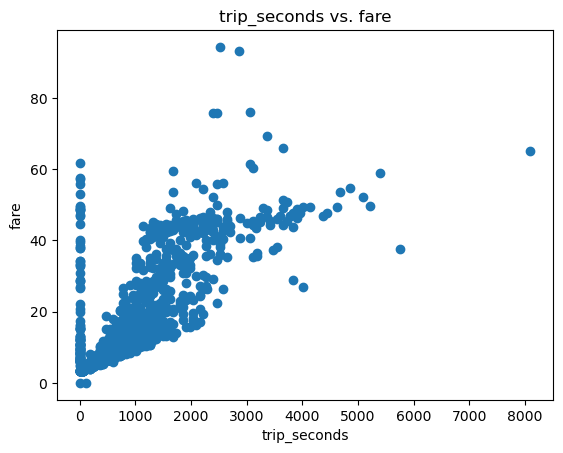

trip_miles vs. fare correlation: 0.6289204573187448


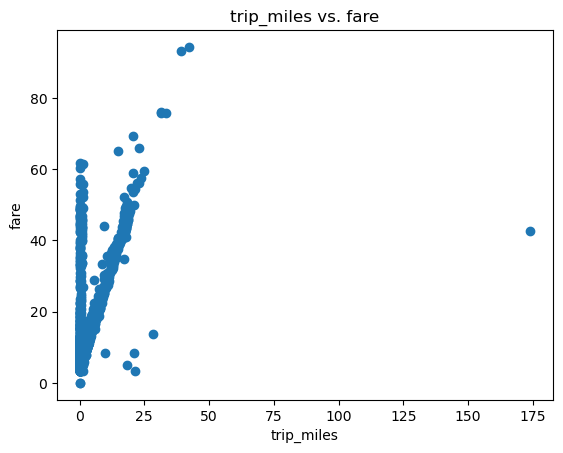

trip_seconds vs. trip_miles correlation: 0.5426771579188657


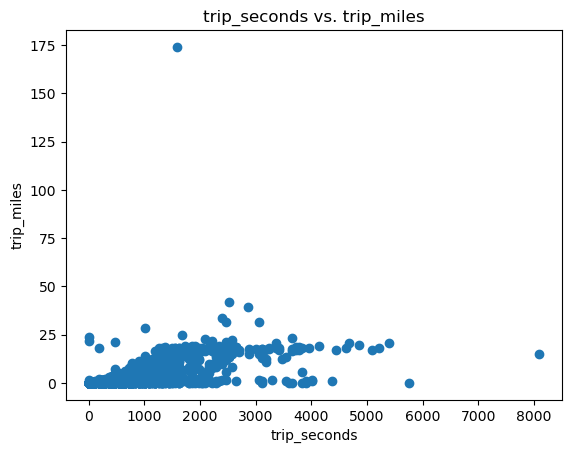

In [11]:
print('trip_seconds vs. fare correlation:',sample_df_pd[['trip_seconds','fare']].corr().fare.iloc[0])
plt.title('trip_seconds vs. fare')
plt.xlabel('trip_seconds')
plt.ylabel('fare')
plt.scatter(data=sample_df_pd,x='trip_seconds',y='fare')
plt.show()

print('trip_miles vs. fare correlation:',sample_df_pd[['trip_miles','fare']].corr().fare.iloc[0])
plt.title('trip_miles vs. fare')
plt.xlabel('trip_miles')
plt.ylabel('fare')
plt.scatter(data=sample_df_pd,x='trip_miles',y='fare')
plt.show()

print('trip_seconds vs. trip_miles correlation:',sample_df_pd[['trip_seconds','trip_miles']].corr().trip_miles.iloc[0])
plt.title('trip_seconds vs. trip_miles')
plt.xlabel('trip_seconds')
plt.ylabel('trip_miles')
plt.scatter(data=sample_df_pd,x='trip_seconds',y='trip_miles')
plt.show()

## Build Predictive Models
**Tasks 3-6:** Forcast fare using trip_seconds and trip_miles by building the following models:
+ **Task 3:** linear regression with elastic net Regularizers.
+ **Task 4:** simple tree model.
+ **Task 5:** random forest model.
+ **Task 6:** Gradient-Boosted Tree

### Linear Regression with Elastic Net Regularizers

In [12]:
# time model
t0 = time()

# build model
lr = LinearRegression(labelCol="fare", featuresCol="scaledFeatures", elasticNetParam=0.8)

# train model
lr_model = lr.fit(df_train)

# fit model to test data and print results
lr_results = lr_model.transform(df_test)
print(lr_results.select("trip_seconds","trip_miles","fare","prediction").show(5,truncate=False))

print("time to run:",round((time()-t0)/60,2),"minutes")

+------------+----------+-----+------------------+
|trip_seconds|trip_miles|fare |prediction        |
+------------+----------+-----+------------------+
|14400       |0.0       |0.01 |107.20708372849504|
|360         |0.8       |5.75 |10.911897319117426|
|1320        |12.7      |33.75|18.418338302327907|
|360         |0.8       |5.75 |10.911897319117426|
|600         |2.0       |8.75 |12.651588651518264|
+------------+----------+-----+------------------+
only showing top 5 rows

None
time to run: 4.83 minutes


### Decision Tree

In [13]:
# time model
t0=time()

# build model
dt = DecisionTreeRegressor(labelCol="fare", featuresCol="scaledFeatures")

# train model
dt_model = dt.fit(df_train)

# fit model to test data and print results
dt_results = dt_model.transform(df_test)
print(dt_results.select("trip_seconds","trip_miles","fare","prediction").show(5,truncate=False))

print("time to run:",round((time()-t0)/60,2),"minutes")

+------------+----------+-----+------------------+
|trip_seconds|trip_miles|fare |prediction        |
+------------+----------+-----+------------------+
|14400       |0.0       |0.01 |47.61376187121686 |
|360         |0.8       |5.75 |5.6960573614360355|
|1320        |12.7      |33.75|34.958589656729906|
|360         |0.8       |5.75 |5.6960573614360355|
|600         |2.0       |8.75 |7.997810188784274 |
+------------+----------+-----+------------------+
only showing top 5 rows

None
time to run: 8.02 minutes


### Random Forest

In [14]:
# time model
t0=time()

# build model
rf = RandomForestRegressor(labelCol="fare", featuresCol="scaledFeatures")

# train model
rf_model = rf.fit(df_train)

# fit model to test data and print results
rf_results = rf_model.transform(df_test)
print(rf_results.select("trip_seconds","trip_miles","fare","prediction").show(5,truncate=False))

print("time to run:",round((time()-t0)/60,2),"minutes")

+------------+----------+-----+------------------+
|trip_seconds|trip_miles|fare |prediction        |
+------------+----------+-----+------------------+
|14400       |0.0       |0.01 |39.444894117387896|
|360         |0.8       |5.75 |6.607122166765592 |
|1320        |12.7      |33.75|31.80359858003167 |
|360         |0.8       |5.75 |6.607122166765592 |
|600         |2.0       |8.75 |8.391800228474375 |
+------------+----------+-----+------------------+
only showing top 5 rows

None
time to run: 10.34 minutes


### Gradient-Boosted Decision Tree

In [15]:
# time model
t0=time()

# build model
gbt = GBTRegressor(labelCol="fare", featuresCol="scaledFeatures")

# train model
gbt_model = gbt.fit(df_train)

# fit model to test data and print results
gbt_results = gbt_model.transform(df_test)
gbt_results.select("trip_seconds","trip_miles","fare","prediction").show(5,truncate=False)

print("time to run:",round((time()-t0)/60,2),"minutes")

+------------+----------+-----+------------------+
|trip_seconds|trip_miles|fare |prediction        |
+------------+----------+-----+------------------+
|14400       |0.0       |0.01 |54.891262944766055|
|360         |0.8       |5.75 |5.640078233447366 |
|1320        |12.7      |33.75|33.001661727883096|
|360         |0.8       |5.75 |5.640078233447366 |
|600         |2.0       |8.75 |8.977311095212148 |
+------------+----------+-----+------------------+
only showing top 5 rows

time to run: 51.69 minutes


## Evaluate Models
**Task 7:** Which model do you recommend to use? Justify your answer.

In [16]:
# set up data frame to organize evaluation metrics for the models

evaluation_df = pd.DataFrame(index=['r2','rmse'],columns=['LR','DT','RF','GBT'])

lr_results.name = 'LR'
dt_results.name = 'DT'
rf_results.name = 'RF'
gbt_results.name = 'GBT'

In [17]:
# time codes
t0 = time()

# calculate r^2 and rmse for each model and add the values to the data frame created above

evaluator = RegressionEvaluator(labelCol="fare",predictionCol="prediction")

for results in [lr_results,dt_results,rf_results,gbt_results]:
    model_r2 = evaluator.evaluate(results,{evaluator.metricName:'r2'})
    evaluation_df.at['r2',results.name] = model_r2
    model_rmse = evaluator.evaluate(results,{evaluator.metricName:'rmse'})
    evaluation_df.at['rmse',results.name] = model_rmse

print("time to run:",round(time()-t0,2),"seconds")
print(evaluation_df)

time to run: 1115.12 seconds
             LR         DT         RF        GBT
r2     0.096522   0.204175   0.205057   0.221636
rmse  23.916262  22.446228  22.433787  22.198619


The Gradient-Boosted Tree model is the best with the highest R^2 value and the lowest RMSE value.

## Model Tuning

**Task 8:** Please perform hyper parameter tuning on the model you selected in step 7 (since it is a huge dataset, you may use 1 parameter for each hyperparameters to save time)

In [18]:
# time codes
t0 = time()

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2])
             .addGrid(gbt.maxBins, [15])
             .addGrid(gbt.maxIter, [10])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(df_train)
predictions = cvModel.transform(df_test)

print("time to run:",round((time()-t0)/60,2),"minutes")

time to run: 97.26 minutes


In [19]:
print('R^2:',evaluator.evaluate(predictions,{evaluator.metricName:'r2'}))
print('RMSE:',evaluator.evaluate(predictions,{evaluator.metricName:'rmse'}))

R^2: 0.1941078823577428
RMSE: 22.58775243399151


## Build Clustering Model
**Task9:** Perform k-means clustering using features trip_seconds, trip_miles, and fare. Please recommend the optimal number of clusters and justify your answer.

In [20]:
dataset = clean_df.select('trip_seconds','trip_miles','fare')
cluster_features=['trip_seconds','trip_miles','fare']
assembler = VectorAssembler(inputCols=cluster_features, outputCol='features') 
dataset = assembler.transform(dataset)

In [21]:
# time codes
t0 = time()

evaluator = ClusteringEvaluator()
Silhvalues = {}

for k in range(2,6):
    kmeans = KMeans().setK(k).setSeed(2003)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    silhouette = evaluator.evaluate(predictions)
    Silhvalues[k] = silhouette
    print(k,'clusters =>',silhouette)
    
print("time to run:",round((time()-t0)/60,2),"minutes")

2 clusters => 0.8141860128531684
3 clusters => 0.8438044667016842
4 clusters => 0.7664291542345014
5 clusters => 0.7384807592737382
time to run: 38.76 minutes


In [22]:
kmeans_evaluation = pd.DataFrame(data={'clusters':list(Silhvalues.keys()),'silhouette_value':list(Silhvalues.values())})
kmeans_evaluation

,clusters,silhouette_value
0,2,0.814186
1,3,0.843804
2,4,0.766429
3,5,0.738481


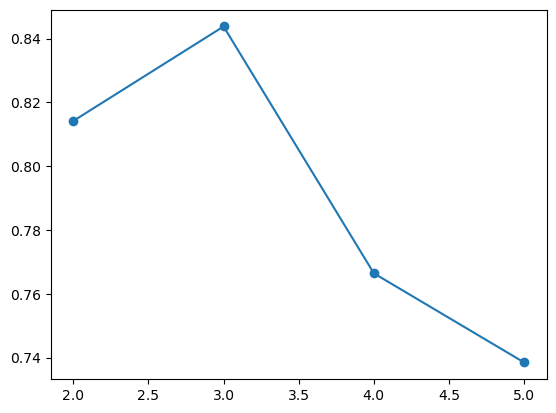

In [23]:
x = np.array(kmeans_evaluation['clusters'])
y = np.array(kmeans_evaluation['silhouette_value'])
plt.scatter(x,y)
plt.plot(x,y)

The optimal number of clusters is 3 because using 3 clusters yields the highest silhouette value.

## Conclusions

In [24]:
end_time = time()
print('Total time to run notebook:',round((end_time-start_time)/3600,2),'hours')

Total time to run notebook: 3.99 hours
